# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime as dt
# % matplotlib inline
import seaborn as sns


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [7]:
transcript[transcript.event == 'offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0



## Data Cleaning
    Transcripts
        Split Value Column into value_id and values
    Profile
        Convert date to appropriate format
        dedup
        Impute missing income values
    Portfolio
        Split channels into column flags
        Dedup

In [8]:
## Unique Channels
available_channels = []

for c_l in portfolio['channels']:
    for c_0 in c_l:
        if c_0 not in available_channels:
            available_channels.append(c_0)

print(available_channels)

['email', 'mobile', 'social', 'web']


In [9]:
# ADD columns as flags for each channel
for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
    
portfolio.drop('channels',axis = 1,inplace = True)

#check column datatypes
print(portfolio.dtypes)

# check if each row is unique
print(len(np.unique(portfolio['id'])) == len(portfolio))
portfolio.head()

reward         int64
difficulty     int64
duration       int64
offer_type    object
id            object
email          int64
mobile         int64
social         int64
web            int64
dtype: object
True


,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [10]:
### Transcript Cleanup

transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])

# we have offer id and offer_id in value_id - let's correc that
transcript['value_type'] = transcript['value_type'].apply(lambda x : 'offer_id' if x == 'offer id' else x)
#check if column name is appropriate
print(transcript.dtypes)

person        object
event         object
value         object
time           int64
value_type    object
dtype: object


In [11]:
transcript.head()

,person,event,value,time,value_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id


In [12]:
### Profile Cleanup

# fill missing geneder with U (unknown)
profile['gender'].fillna('U',inplace = True)

# check columns dtypes
print(profile.dtypes)

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object


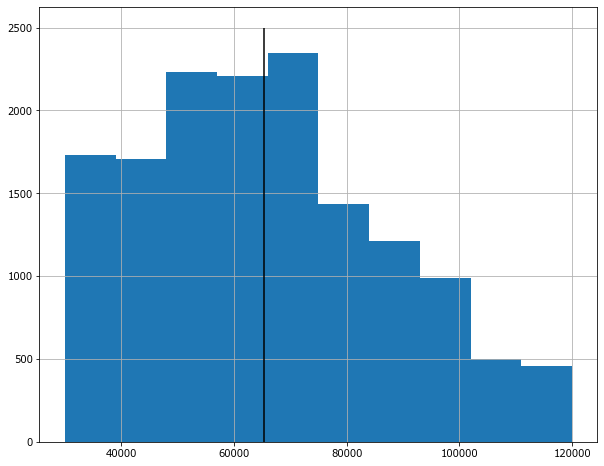

In [13]:
## Plot Distribution of Income
profile.income.hist(bins = 10, figsize = (10,8))
plt.vlines(profile.income.mean(),0,2500) # mean

# mean looks like an appropriate value for imputation

In [14]:
mean_income = profile.income.mean()
profile['income'].fillna(mean_income, inplace = True)

In [15]:
# convert beacame_member_on into datetime format, also extract month, year, day from same
profile.head()
profile['member_year'] = profile['became_member_on'].apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile['became_member_on'].apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile['became_member_on'].apply(lambda x: int(str(x)[6:]))

profile['member_date'] = profile['became_member_on'].apply(lambda x: dt.datetime.strptime(str(x),'%Y%m%d'))
profile.drop('became_member_on',axis = 1,inplace = True)

In [16]:
profile.head()

,gender,age,id,income,member_year,member_month,member_day,member_date
0,U,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,U,118,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,U,118,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


# Exploratory Analysis

## By Gender

C:\Users\mm13690\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Proportion of Population')

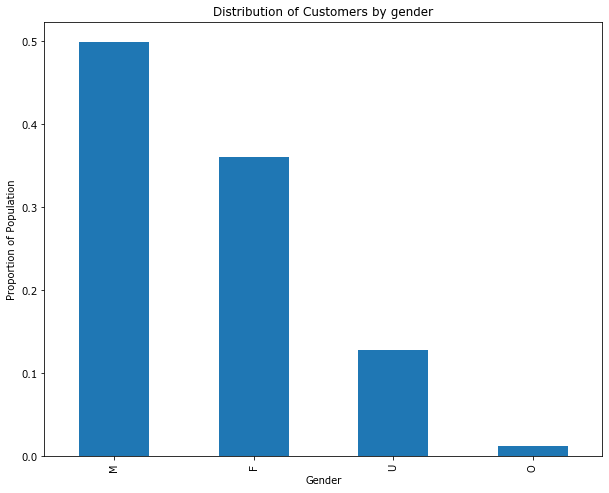

In [17]:
profile.gender.value_counts(normalize = True).plot('bar',figsize = (10,8))
plt.title('Distribution of Customers by gender')
plt.xlabel('Gender')
plt.ylabel('Proportion of Population')

Almost 50% are males, while rest (Female, Unknow and others) make the rest

Text(1, 65904.9915682968, 'Overall Average Income')

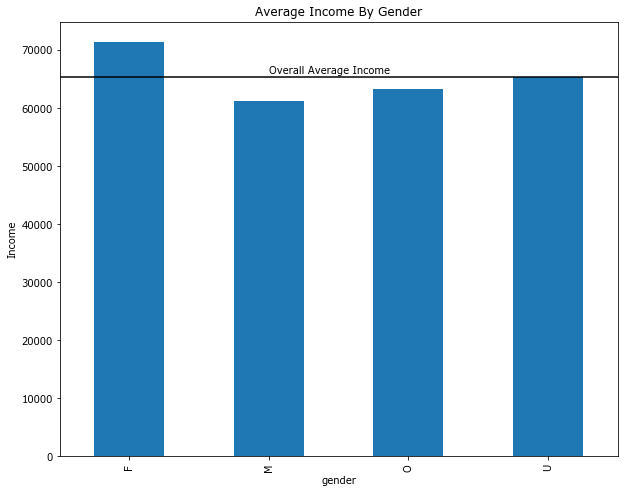

In [18]:
gender_income = profile.groupby('gender',as_index = False).agg({'income':'mean'})
gender_income.plot(kind = 'bar',x = 'gender',y = 'income',legend = False,figsize = (10,8))
plt.hlines(mean_income,-100,100)
plt.ylabel('Income')
plt.title('Average Income By Gender')
plt.text(1,mean_income+500,'Overall Average Income')


Female customer on average have higher income (hmm interesting?)

Text(-0.2, 66404.9915682968, 'Overall Average Income')

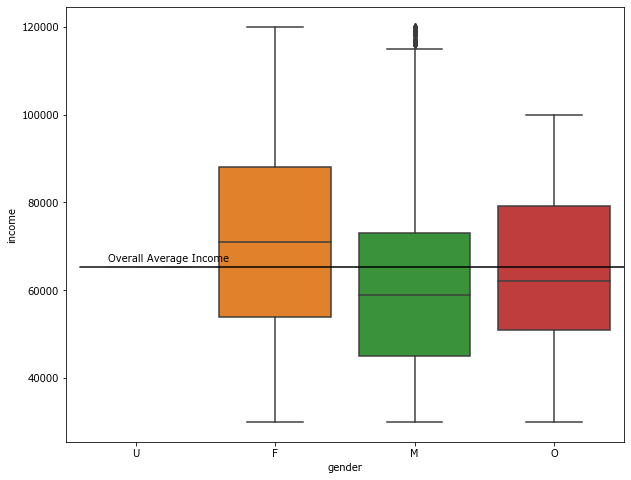

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(x='gender',y='income',data=profile)
plt.hlines(mean_income,0,3.5)
plt.text(x = -0.20,y = mean_income+1000,s = 'Overall Average Income')

Unknowns have been imputed by mean, so they don't have a distribution, females in terms of avg income fare as good as upper quantile of men


## Customer Sign Ups

Text(0.5, 1.0, 'Trend in # Sign Ups')

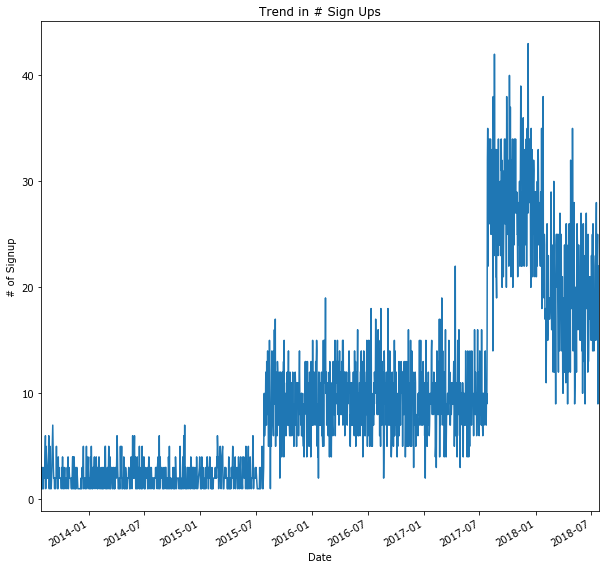

In [20]:
profile.member_date.value_counts().plot(kind = 'line',figsize = (10,10))
plt.xlabel('Date')
plt.ylabel('# of Signup')
plt.title("Trend in # Sign Ups")

There are two distince instances - wherein we see a large jump in signups. Also there is period right around the beginning of 2018 wherein we see a drop in signups.

## Customer Transactions

In [21]:
transcript.head()

,person,event,value,time,value_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id


In [22]:
# Unique events
# print(transcript.event.unique())

## Distribution of Events
transcript.event.value_counts(normalize = True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [23]:
# A specific offer received , viewed and completed on the same day

transcript[(transcript['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f') 
           & (transcript['value'] == '2906b810c7d4411798c6938adc9daaa5')]

,person,event,value,time,value_type
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,2906b810c7d4411798c6938adc9daaa5,0,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id


In [24]:
portfolio[portfolio['id'] == '2906b810c7d4411798c6938adc9daaa5']

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [25]:
trans_offer = pd.merge(transcript[transcript['event'] == 'offer completed'],
                       portfolio, how = 'inner',left_on = 'value',right_on = 'id')

In [26]:
trans_offer.offer_type.value_counts(normalize = True) # split between discount and bogo is 50/50

discount    0.533369
bogo        0.466631
Name: offer_type, dtype: float64

# Data Analysis
## Offer Analysis

Lets look at the transactions, offer etc. used by one customer, to get a better idea of typical transactions

In [27]:
# purchase of one customer
test_person_transactions = transcript[(transcript['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f') &
                                     (transcript['value_type'] == 'amount')].reset_index()
test_person_transactions['DaysPrevPurchase'] = test_person_transactions.time.diff()
test_person_transactions.iloc[0,-1] = test_person_transactions.loc[0,'time']
test_person_transactions['value'] = test_person_transactions['value'].apply(lambda x: float(x))
test_person_transactions.drop('index',axis = 1,inplace = True)
test_person_transactions.head(10)

,person,event,value,time,value_type,DaysPrevPurchase
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount,0.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,21.55,42,amount,42.0
2,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,32.87,114,amount,72.0
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,19.99,156,amount,42.0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,20.97,168,amount,12.0
5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,31.09,204,amount,36.0
6,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,18.42,354,amount,150.0
7,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,29.71,390,amount,36.0
8,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,32.53,396,amount,6.0
9,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,33.36,402,amount,6.0


In [28]:
# this  person, his average spend , average days between two transactions and total time since he's been a member
test_person_transactions.groupby('person').agg({'value':'mean','DaysPrevPurchase':'mean','time':'max'})

,value,DaysPrevPurchase,time
person,,,
9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,26.706667,45.0,540



## Promotion Activity

In [29]:
# let's have a look at received and completed transactions
test_completion = pd.merge(transcript[transcript['event'] == 'offer received'],
                           transcript[transcript['event'] == 'offer completed'],how = 'left',left_on = ['person','value'],
                          right_on = ['person', 'value'])

In [30]:
test_completion.head()

,person,event_x,value,time_x,value_type_x,event_y,time_y,value_type_y
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id,offer completed,132.0,offer_id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id,NaN,NaN,NaN


In [31]:
# person can received same offer multiple times, therefore we have mltiple joins- but we want only those offers 
#which aligns correctly with time


# offers which were completed within maximum duration or were never completed


completion = test_completion[((test_completion['time_y'] <= (test_completion['time_x'] + 20)) &
                            (test_completion['time_y'] >= (test_completion['time_x']))) |
                            (pd.isnull(test_completion['event_y']) == True)][['person','time_x','value','event_y','time_y']]
completion['DaysToCompleteOffer'] = completion['time_y'] - completion['time_x']
completion['CompletedOffer'] = completion['event_y'].apply(lambda x : 0 if pd.isnull(x) == True else 1)
completion.head()

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0
7,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0


In [32]:
completion.tail()

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
86425,f924927e7f844ecebf87eef93f4d2688,576,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1
86431,e4052622e5ba45a8b96b59aba68cf068,576,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,0


In [33]:
# let's look at individuals

completion[completion['person'] =='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f' ]

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
40,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer completed,0.0,0.0,1
28595,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,354.0,18.0,1


In [34]:
portfolio[portfolio['id'] == '2298d6c36e964ae4a3e7e9706d1fb8c2']

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1


In [35]:
completion[completion['person'] =='9dc1421481194dcd9400aec7c9ae6366' ]

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
57550,9dc1421481194dcd9400aec7c9ae6366,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,414.0,6.0,1
86430,9dc1421481194dcd9400aec7c9ae6366,576,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1


In [36]:
# calculate a person completed offer stat
completion[completion['person'] =='9dc1421481194dcd9400aec7c9ae6366'].groupby(['person']).agg({
    'time_x':'min','CompletedOffer':'mean','DaysToCompleteOffer':'mean'
})

,time_x,CompletedOffer,DaysToCompleteOffer
person,,,
9dc1421481194dcd9400aec7c9ae6366,408,1,12.0



## Does the type of offer determines if an individual will complete an offer and how long will it take to complete?


In [37]:
# merge completed/non completed offer with offer type

offers_final_df = pd.merge(completion, portfolio, how = 'inner', 
                           left_on = 'value',right_on = 'id')[['person','time_x','value','DaysToCompleteOffer',
                                                              'CompletedOffer','offer_type','difficulty','duration','reward','email',
                                                              'mobile','social','web']]
offers_final_df.rename(columns = {'time_x':'offer_time'},inplace = True)

offers_final_df['NetReward'] = offers_final_df['reward'] - offers_final_df['difficulty']

In [38]:
offers_final_df.head()

,person,offer_time,value,DaysToCompleteOffer,CompletedOffer,offer_type,difficulty,duration,reward,email,mobile,social,web,NetReward
0,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,discount,20,10,5,1,0,0,1,-15
1,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,discount,20,10,5,1,0,0,1,-15
2,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,discount,20,10,5,1,0,0,1,-15
3,744d603ef08c4f33af5a61c8c7628d1c,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,discount,20,10,5,1,0,0,1,-15
4,3d02345581554e81b7b289ab5e288078,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,discount,20,10,5,1,0,0,1,-15


In [39]:
overall_offers_df = offers_final_df.groupby(['offer_type','difficulty','reward'],as_index = False).agg({
    'CompletedOffer':['mean','sum'],'DaysToCompleteOffer':'mean','NetReward':'max'})

overall_offers_df.columns.droplevel(1)
overall_offers_df.columns = ['offer_type', 'difficulty', 'reward', 'CompletedOffers',
       'TotalCompletedOffer', 'DaysToCompleteOffer', 'NetReward']
overall_offers_df['NetWorth'] = overall_offers_df['CompletedOffers'] * overall_offers_df['NetReward'] * -1
final_overall_offers_df = overall_offers_df[overall_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletedOffer,DaysToCompleteOffer,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


In above table Net Reward is on an average, how much reward does a customer get if they use a Starbucks offer and NetWroth calculates the money startbcks on an average makes for a similar offer. This points that starbucks makes maximum 2.2 $ out of a particular type of offer. Using this one could determine the overall profitability of floating an order for starbucks

## Individual Metrics

To get our clusters together, we now need to bring all of the above metrics at an individual level

In [40]:
all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

C:\Users\mm13690\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,person,event,value,time,value_type
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0,amount
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0,amount
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0,amount
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0,amount


In [42]:
df_all_customers = pd.DataFrame(columns=['person','discount_total_offers','discount_completion_pct',
                                       'discount_min_completion_days','discount_max_completion_days',
                                       'discount_completed_offers','discount_avg_completion_days',
                                       'discount_avg_net_reward',
                                       'bogo_total_offers','bogo_completion_pct',
                                       'bogo_min_completion_days','bogo_max_completion_days',
                                       'bogo_completed_offers','bogo_avg_completion_days',
                                       'bogo_avg_net_reward','informational_promotions','age','gender',
                                       'income','member_date','total_transactions','min_transaction_day',
                                       'max_transaction_day','avg_transaction','total_transaction_amount',
                                       'median_days_between_purchase','avg_days_between_purchase'])

for person in np.unique(profile['id'])[:1000]:
    # get individual profile info
    personal_profile = profile[profile['id'] == person][['id','age','gender','income','member_date']]
    
    #get transaction info
    personal_transactions = all_transactions[all_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        
        personal_transactions['DaysFromLastPurchase'] =  personal_transactions.time.diff()
        
        personal_transactions.iloc[0,-1] = personal_transactions.loc[0,'time']
        
        personal_agg_trans = personal_transactions.groupby('person',as_index = False).agg({'time':['count','min','max'],
        'value':['mean','sum'],'DaysFromLastPurchase':['median','mean']})
        
        personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1)
        
        personal_agg_trans.columns = ['person','total_transactions','min_transaction_day',
                                       'max_transaction_day','avg_transaction','total_transaction_amount',
                                       'median_days_between_purchase','avg_days_between_purchase']
        
    else:
        null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,np.nan]
        personal_agg_trans = pd.DataFrame([null_array],columns=['person','total_transactions','min_transaction_day',
                                   'max_transaction_day','avg_transaction','total_transaction_amount',
                                   'median_days_between_purchase','avg_days_between_purchase'])

    personal_df_1 = pd.merge(personal_profile,personal_agg_trans,how = 'inner',left_on = 'id',
                            right_on = 'person')
    personal_df_1.drop('id',axis = 1,inplace = True)

    # look at the different promotions person interacted with
    # using global values to join data in next step

    for offer_type in ['discount','bogo']:
        globals()[offer_type + '_df'] = offers_final_df[(offers_final_df['person'] == person) &
                                                      (offers_final_df['offer_type'] == offer_type)
                                                      ].groupby('person',as_index = False).agg({
             'CompletedOffer':['count','mean','sum'], 'DaysToCompleteOffer': ['min','max','mean'],
              'NetReward': ['mean']})
        globals()[offer_type + '_df'].columns = globals()[offer_type+'_df'].columns.droplevel(1)
        globals()[offer_type + '_df'].columns = ['person', offer_type + '_total_offers'
                                ,offer_type + '_completion_pct', offer_type + '_completed_offers'
                               , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
                                ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']

        if len(globals()[offer_type + '_df']) == 0:
            null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
            globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
                dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
            )            
    bogo_and_discounts = pd.merge(discount_df,bogo_df)
    bogo_and_discounts['information_promotions'] = len(offers_final_df[(offers_final_df['person'] == person)
                                                           & (offers_final_df['offer_type'] == 'informational')])

    # bring everything together
    person_final = pd.merge(bogo_and_discounts,personal_df_1)
    # append person
    df_all_customers = df_all_customers.append(person_final)

 
        

In [43]:
# check if the number of people are same
len(df_all_customers) == len(profile)

False

In [44]:
df_all_customers.head()

,age,avg_days_between_purchase,avg_transaction,bogo_avg_completion_days,bogo_avg_net_reward,bogo_completed_offers,bogo_completion_pct,bogo_max_completion_days,bogo_min_completion_days,bogo_total_offers,...,income,information_promotions,informational_promotions,max_transaction_day,median_days_between_purchase,member_date,min_transaction_day,person,total_transaction_amount,total_transactions
0,33,87.0,15.950000,6.0,0,1,1,6.0,6.0,1,...,72000.000000,2.0,NaN,696,57.0,2017-04-21,228,0009655768c64bdeb2e877511632db8f,127.60,8
0,118,158.0,1.363333,NaN,0,0,0,NaN,NaN,2,...,65404.991568,0.0,NaN,474,162.0,2018-04-25,294,00116118485d4dfda04fdbaba9a87b5c,4.09,3
0,40,130.8,15.892000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57000.000000,2.0,NaN,654,120.0,2018-01-09,132,0011e0d4e6b944f998e987f904e8c1e5,79.46,5
0,59,88.5,24.607500,NaN,0,0,0,NaN,NaN,1,...,90000.000000,1.0,NaN,708,42.0,2016-03-04,54,0020c2b971eb4e9188eac86d93036a77,196.86,8
0,24,56.0,12.837500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.000000,1.0,NaN,672,39.0,2016-11-11,42,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12


## Clustering

In [45]:
from sklearn import cluster
from sklearn.cluster import KMeans

In [46]:
df_all_customers.columns

Index(['age', 'avg_days_between_purchase', 'avg_transaction',
       'bogo_avg_completion_days', 'bogo_avg_net_reward',
       'bogo_completed_offers', 'bogo_completion_pct',
       'bogo_max_completion_days', 'bogo_min_completion_days',
       'bogo_total_offers', 'discount_avg_completion_days',
       'discount_avg_net_reward', 'discount_completed_offers',
       'discount_completion_pct', 'discount_max_completion_days',
       'discount_min_completion_days', 'discount_total_offers', 'gender',
       'income', 'information_promotions', 'informational_promotions',
       'max_transaction_day', 'median_days_between_purchase', 'member_date',
       'min_transaction_day', 'person', 'total_transaction_amount',
       'total_transactions'],
      dtype='object')

In [47]:
X = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers', 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchase', 'avg_days_between_purchase']].fillna(0)

X_new = pd.get_dummies(data = X, columns = ['gender'])

Text(0.5, 1.0, 'SSE vs. K')

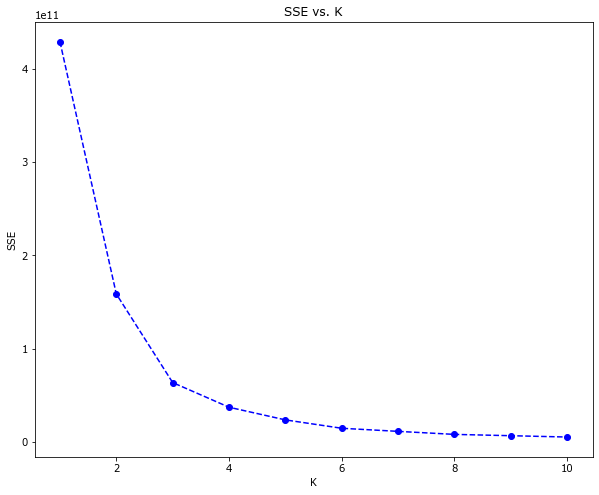

In [48]:
scores = []

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(X_new)
    
    scores.append(abs(model.score(X_new)))
    
plt.figure(figsize = (10,8))
plt.plot(range(1,11),scores,linestyle = '--',marker = 'o',color = 'b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [49]:
kmeans = KMeans(4)




# id not considered
X = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers', 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchase', 'avg_days_between_purchase']].fillna(0)
X_new = pd.get_dummies(X,columns=['gender'])

model = kmeans.fit(X_new)


df_all_customers['Cluster_4'] = model.fit_predict(X_new)

In [51]:
df_all_customers.head()
df_all_customers.Cluster_4.value_counts(normalize = True)

1    0.402
2    0.244
0    0.231
3    0.123
Name: Cluster_4, dtype: float64

C:\Users\mm13690\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\mm13690\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


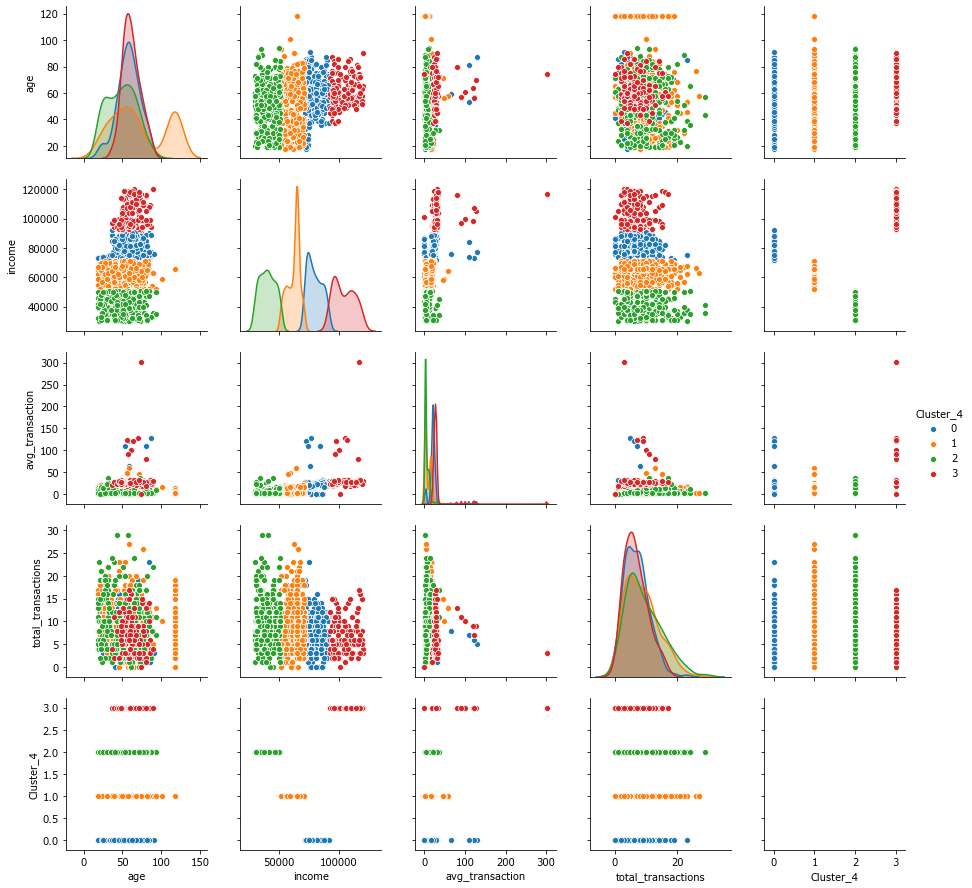

In [53]:
# Look at pairpolots to compare features in different clusters

visual_columns = ['age','gender','income','avg_transaction','total_transactions',
                 'Cluster_4']

sns_personal_attributes = sns.pairplot(df_all_customers[visual_columns].fillna(0),hue = 'Cluster_4')


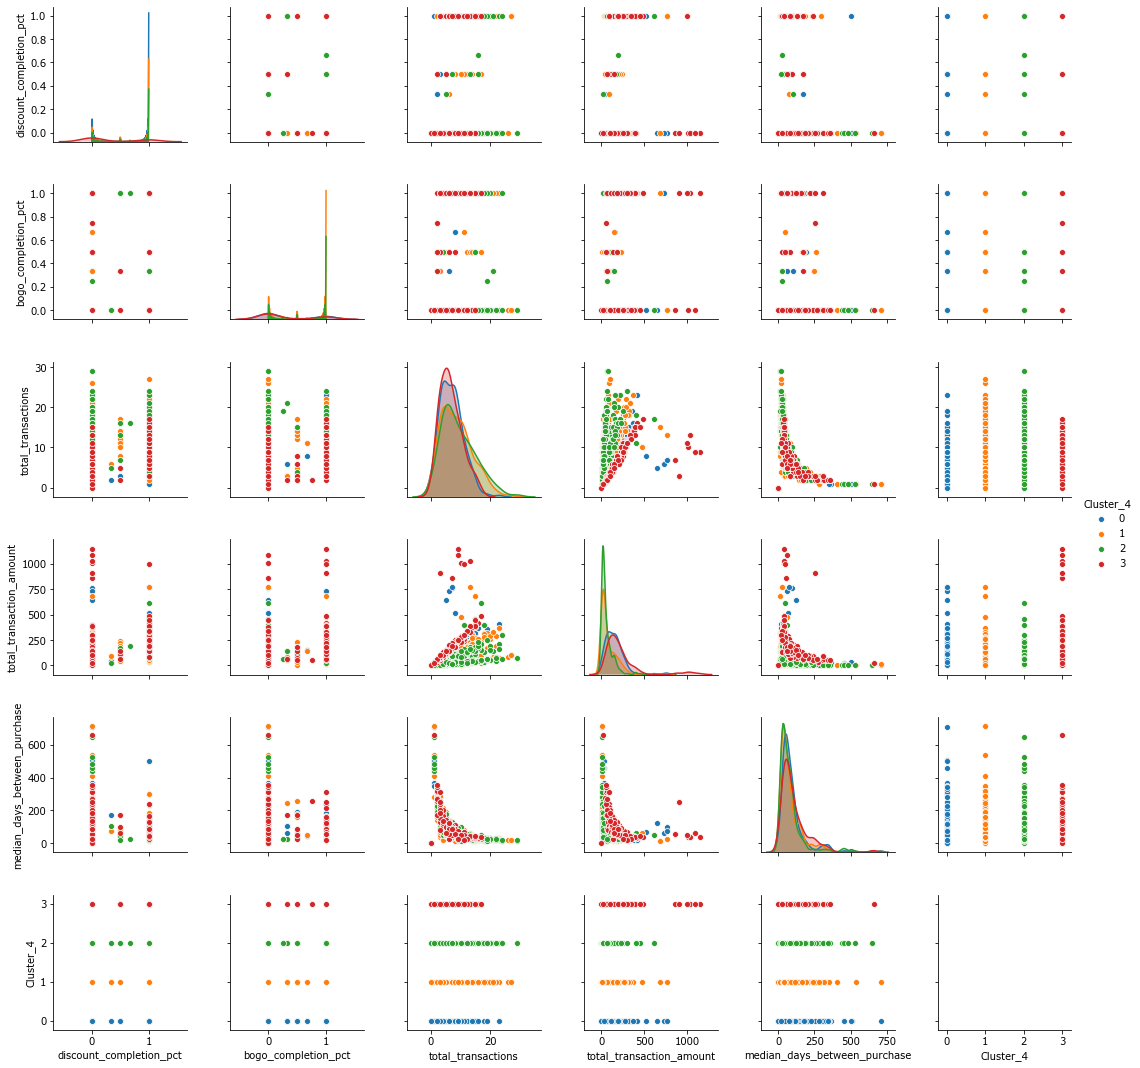

In [54]:
# Transactional Information
visual_columns = ['discount_completion_pct','bogo_completion_pct',
        'total_transactions', 'total_transaction_amount',
       'median_days_between_purchase','Cluster_4']
seaborn_trans_info = sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Cluster_4')
seaborn_trans_info.savefig("personal_transactions_clusters.png")

<Figure size 720x576 with 0 Axes>

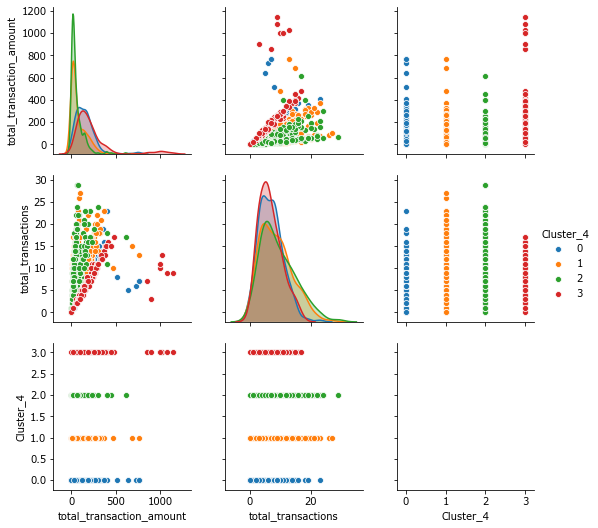

In [55]:
# Look to see cluster trends on total spending and total number of transactions
plt.figure(figsize= (10,8))
sns.pairplot(df_all_customers[['total_transaction_amount','total_transactions','Cluster_4']].fillna(0), hue='Cluster_4');

<Figure size 1440x720 with 0 Axes>

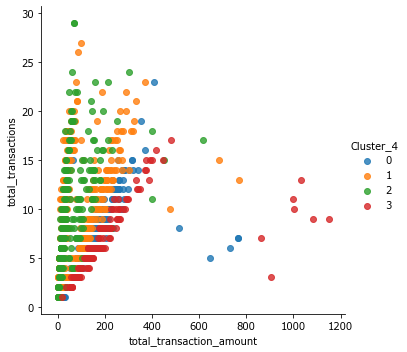

In [56]:
plt.figure(figsize = (20,10))
sns.lmplot(x='total_transaction_amount', y='total_transactions', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False);


<Figure size 1440x1440 with 0 Axes>

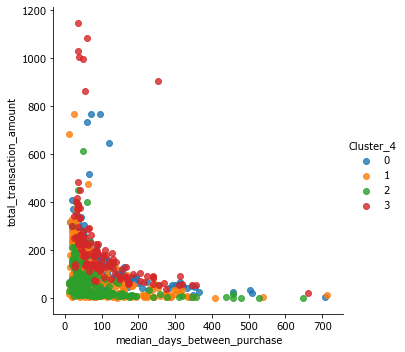

In [57]:
plt.figure(figsize = (20,20));
sns.lmplot(x='median_days_between_purchase', y='total_transaction_amount', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False);

<Figure size 720x576 with 0 Axes>

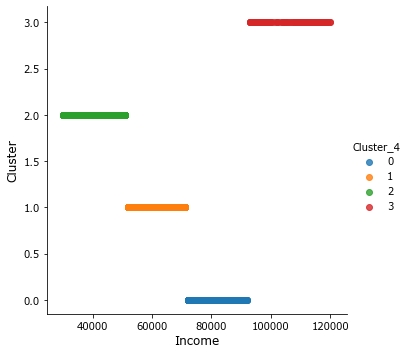

<Figure size 720x576 with 0 Axes>

In [58]:

# Cluster and income distirbution
# You can see that this really splits the distribution of income apart
sns.lmplot(x='income', y='Cluster_4', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False)
plt.xlabel('Income', fontsize = 12)
plt.ylabel('Cluster', fontsize = 12)
plt.figure(figsize=(10,8))

In [59]:
clust_offer_aggs = pd.merge(offers_final_df, df_all_customers[['person','Cluster_4']]).groupby(
                            ['Cluster_4','offer_type','difficulty','reward']
                            , as_index = False ).agg({

     'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

clust_offer_aggs = clust_offer_aggs[clust_offer_aggs['offer_type'] != 'informational']
clust_offer_aggs.columns.droplevel(1)
clust_offer_aggs.columns = ['Cluster_4','offer_type','difficulty','reward'
                           , 'CompletedOffers','TotalCompletions','AvgDaysToCompleteOffer','NetReward']

In [60]:
clust_offer_aggs

,Cluster_4,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToCompleteOffer,NetReward
0,0,bogo,5,5,0.472527,43,6.558140,0
1,0,bogo,10,10,0.673913,62,7.838710,0
2,0,discount,7,3,0.562500,18,8.333333,-4
3,0,discount,10,2,0.484848,32,9.187500,-8
4,0,discount,20,5,0.369565,17,7.411765,-15
6,1,bogo,5,5,0.295964,66,9.272727,0
7,1,bogo,10,10,0.139130,32,9.562500,0
8,1,discount,7,3,0.236559,22,7.636364,-4
9,1,discount,10,2,0.246445,52,8.192308,-8
10,1,discount,20,5,0.034783,4,15.000000,-15
